In [1]:
!pip3 install transformers

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print("There are %d GPU(s) available." % torch.cuda.device_count())

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not...
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [3]:
import random
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import (
    DataLoader,
    Sampler,
    TensorDataset,
    WeightedRandomSampler,
    random_split,
)
from transformers import (
    AdamW,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
    GPT2Config,
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
    get_linear_schedule_with_warmup,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import numpy as np


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [95]:
from sklearn.metrics import matthews_corrcoef

In [96]:
def matthews(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return matthews_corrcoef(pred_flat, labels_flat)

Get data:

In [97]:
zipurl = "https://nyu-mll.github.io/CoLA/cola_public_1.1.zip"
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall("data")

In [98]:
!ls data/cola_public/raw

in_domain_dev.tsv  in_domain_train.tsv	out_of_domain_dev.tsv


In [7]:
tokenizer_bert = BertTokenizer.from_pretrained(
    "bert-base-uncased",
    do_lower_case=True,
)

In [8]:
tokenizer_gtp2 = GPT2Tokenizer.from_pretrained(
    "gpt2",
    do_lower_case=True,
)
tokenizer_gtp2.pad_token = tokenizer_gtp2.eos_token

In [99]:
def preprocess(df, tokenizer, bs=60, split=True):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    texts = df.iloc[:, 2].to_list()
    labels = torch.from_numpy(df.iloc[:, 0].to_numpy())

    def get_ids(texts):
        input_ids = []
        attention_masks = []

        for sent in texts:
            encoded_dict = tokenizer.encode_plus(
                sent,  # Sentence to encode.
                add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                max_length=64,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors="pt",  # Return pytorch tensors.
            )
            input_ids.append(encoded_dict["input_ids"])
            attention_masks.append(encoded_dict["attention_mask"])
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        return input_ids, attention_masks

    input_ids, attention_masks = get_ids(texts)
    labels = torch.tensor(labels)

    counts = np.bincount(labels.numpy())
    labels_weights = 1.0 / counts
    weights = labels_weights[labels.numpy()]

    dataset = TensorDataset(input_ids, attention_masks, labels)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    if split:
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        dataloader_train = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        dataloader_val = DataLoader(val_dataset, batch_size=bs, shuffle=True)

        return dataloader_train, dataloader_val
    else:
        return DataLoader(dataset, batch_size=bs, shuffle=True)

In [100]:
df = pd.read_csv(
    "data/cola_public/raw/in_domain_train.tsv",
    sep="\t",
    names=["Grammaticality", "Empty", "Sentence"],
)

dataloader_train_bert, dataloader_val_bert = preprocess(df, tokenizer_bert)
dataloader_train_gpt2, dataloader_val_gpt2 = preprocess(df, tokenizer_gtp2)

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_48591/4208486169.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [101]:
df.sample(10)

,Grammaticality,Empty,Sentence
b_82,1,NaN,This book I enjoyed.
ks08,1,NaN,Up what did he look?
bc01,1,NaN,John saw the man in the room.
l-93,0,*,Tony broke herself on the ann.
ad03,0,*,Ron asked that the potion was ready
c_13,0,*,I expect to double more than my profits.
l-93,1,NaN,The bag is bulging.
bc01,0,*,Runs Mary the marathon?
sks13,1,NaN,Whether she will win is a question Mary never ...
c_13,0,*,Jennie smiled the sandwich.


In [102]:
df_test = pd.read_csv(
    "data/cola_public/raw/in_domain_dev.tsv",
    sep="\t",
    names=["Grammaticality", "Empty", "Sentence"],
)

dataloader_test_id_bert = preprocess(df_test, tokenizer_bert, split=False, bs=100)
dataloader_test_id_gpt2 = preprocess(df_test, tokenizer_gtp2, split=False, bs=100)

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_48591/4208486169.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [103]:
df_test = pd.read_csv(
    "data/cola_public/raw/out_of_domain_dev.tsv",
    sep="\t",
    names=["Grammaticality", "Empty", "Sentence"],
)

dataloader_test_od_bert = preprocess(df_test, tokenizer_bert, split=False, bs=100)
dataloader_test_od_gpt2 = preprocess(df_test, tokenizer_gtp2, split=False, bs=100)

/tmp/ipykernel_48591/4208486169.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [105]:
import random

import numpy as np


def train(model, dataloader_t, dataloader_w, seed_val=42, epochs=3):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    losses_tr = []
    losses_ev = []

    training_stats = []

    for epoch_i in range(0, epochs):
        total_train_loss = 0
        model.train()
        for step, batch in enumerate(dataloader_t):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            out = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )

            loss = out[0]
            logits = out[1]
            total_train_loss += loss.item()
            # losses_tr.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(dataloader_t)
        losses_tr.append(avg_train_loss)
        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        total_eval_MCC = 0

        for batch in dataloader_w:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():
                out = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                )

            loss = out[0]
            logits = out[1]
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            total_eval_MCC += matthews(logits, label_ids)

        avg_val_accuracy = total_eval_accuracy / len(dataloader_w)
        # avg_val_MCC = total_eval_MCC / len(dataloader_w)
        avg_val_loss = total_eval_loss / len(dataloader_w)
        print(f"Eval accuracy: {round(avg_val_accuracy, 4)}, eval loss: {round(avg_val_loss, 4)}")
        losses_ev.append(avg_val_loss)
    return losses_tr, losses_ev

In [111]:
# model.eval()
def test_model(model, dataloader):
    total_eval_accuracy = 0
    total_eval_loss = 0
    avg_val_loss = 0
    total_eval_MCC = 0

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            out = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )

            loss = out[0]
            logits = out[1]
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            total_eval_MCC += matthews(logits, label_ids)

    avg_accuracy = total_eval_accuracy / len(dataloader)
    avg_MCC = total_eval_MCC / len(dataloader)
    avg_loss = total_eval_loss / len(dataloader)
    print(f"Test accuracy: {round(avg_accuracy, 4)}, test loss: {round(avg_loss, 4)}, test MCC: {round(avg_MCC, 4)}")

### 1. Bert

In [107]:
model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model_bert.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [108]:
optimizer = AdamW(
    model_bert.parameters(),
    lr=2e-5,
    eps=1e-8,
)

In [109]:
epochs = 3

total_steps = len(dataloader_train_bert) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Default value in run_glue.py
    num_training_steps=total_steps,
)

In [110]:
losses_tr, losses_ev = train(model_bert, dataloader_train_bert, dataloader_val_bert, epochs=epochs)

  Accuracy: 0.82
  MCC: 0.53
  Accuracy: 0.82
  MCC: 0.54
  Accuracy: 0.82
  MCC: 0.54


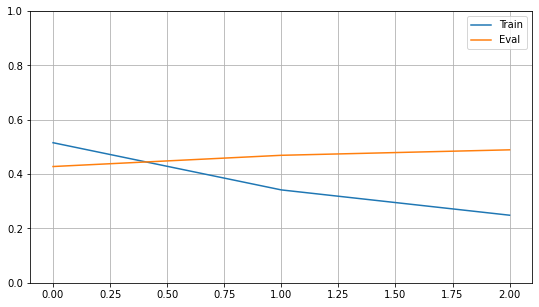

In [112]:
plt.figure(figsize=(9, 5))
plt.plot(losses_tr, label='Train')
plt.plot(losses_ev, label='Eval')
plt.legend()
plt.ylim(0, 1)
plt.grid()

In [113]:
test_model(model_bert, dataloader_test_id_bert)

Test accuracy: 0.8246, test loss: 0.4631, test MCC: 0.5726


In [114]:
test_model(model_bert, dataloader_test_od_bert)

Test accuracy: 0.8171, test loss: 0.5366, test MCC: 0.5499


In [115]:
torch.cuda.empty_cache()

### 2. GPT2

In [116]:
model_gpt2 = GPT2ForSequenceClassification.from_pretrained(
    "gpt2",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)
model_gpt2.config.pad_token_id = model_gpt2.config.eos_token_id
model_gpt2.cuda()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=Fal

In [117]:
optimizer = AdamW(
    model_gpt2.parameters(),
    lr=5e-5,
    eps=1e-8,
)

In [118]:
epochs = 10

total_steps = len(dataloader_train_gpt2) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Default value in run_glue.py
    num_training_steps=total_steps,
)

In [119]:
losses_tr, losses_ev = train(
    model_gpt2, dataloader_train_gpt2, dataloader_val_gpt2, epochs=epochs
)

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  Accuracy: 0.67
  MCC: -0.03


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  Accuracy: 0.69
  MCC: 0.12


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  Accuracy: 0.72
  MCC: 0.25
  Accuracy: 0.75
  MCC: 0.41
  Accuracy: 0.76
  MCC: 0.41
  Accuracy: 0.75
  MCC: 0.40
  Accuracy: 0.75
  MCC: 0.39
  Accuracy: 0.77
  MCC: 0.43
  Accuracy: 0.77
  MCC: 0.43
  Accuracy: 0.78
  MCC: 0.44


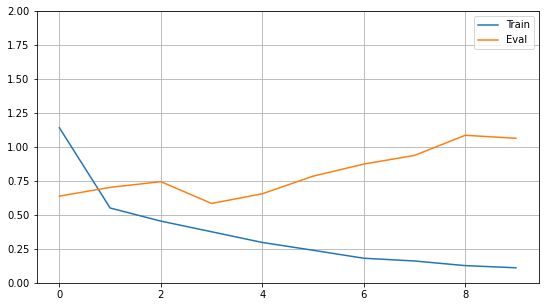

In [123]:
plt.figure(figsize=(9, 5))
plt.plot(losses_tr, label='Train')
plt.plot(losses_ev, label='Eval')
plt.legend()
plt.ylim(0, 2)
plt.grid()

In [126]:
test_model(model_gpt2, dataloader_test_id_gpt2)

Test accuracy: 0.8208, test loss: 0.8069, test MCC: 0.5321


In [127]:
test_model(model_gpt2, dataloader_test_od_gpt2)

Test accuracy: 0.7412, test loss: 1.1424, test MCC: 0.3616
